## <center> Обучение без учителя: кластеризация

В этом задании мы разберемся как работают методы кластеризации данных.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [4]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
X_train.shape

(7352, 561)

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [7]:
X = np.vstack([X_train,X_test])
y = np.hstack([y_train,y_test])

In [7]:
X

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.34996609,  0.03007744, -0.11578796, ..., -0.65535684,
         0.27447878,  0.18118355],
       [ 0.23759383,  0.01846687, -0.09649893, ..., -0.65971859,
         0.26478161,  0.18756291],
       [ 0.15362719, -0.01843651, -0.13701846, ..., -0.66008023,
         0.26393619,  0.1881034 ]])

In [7]:
y

array([5, 5, 5, ..., 2, 2, 2])

Определим число уникальных значений меток целевого класса.

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию


Отмасштабируем выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled

array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])

Сделаем кластеризацию данных методом `KMeans`. В данном случае известно, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
kmeans=KMeans(n_clusters=6,n_init=100,random_state=123)
kmeans.fit(X)
cluster_labels=kmeans.labels_

Посмотрим на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [5]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

NameError: name 'y' is not defined

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 1:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>


In [1]:
ratio_activity = tab[['cluster' + str(i + 1) for i in range(6)]].max(axis=1)[:-1]/tab['все'][:-1]
print(ratio_activity)

print(f'{tab.index[ratio_activity.argmax()]} - {ratio_activity.max():.2f}')

NameError: name 'tab' is not defined

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте критерии инерции и силуэта, рассмотренные на практикуме, чтобы определить оптимальное количество кластеров (параметры алгоритма и данные используем те же, что раньше, изменяем только `n_clusters`)

In [53]:
inertia = []
for l_i in range(1, 10):
    kmeans = KMeans(n_clusters=l_i,n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [54]:
inertia

[558471.6219466812,
 240750.84655957052,
 218503.63979632081,
 197623.85868489946,
 188418.66809805148,
 182168.8965873421,
 176885.06258505135,
 172974.02686894994,
 169368.91389435573]

Text(0.5, 1.0, 'Inertia')

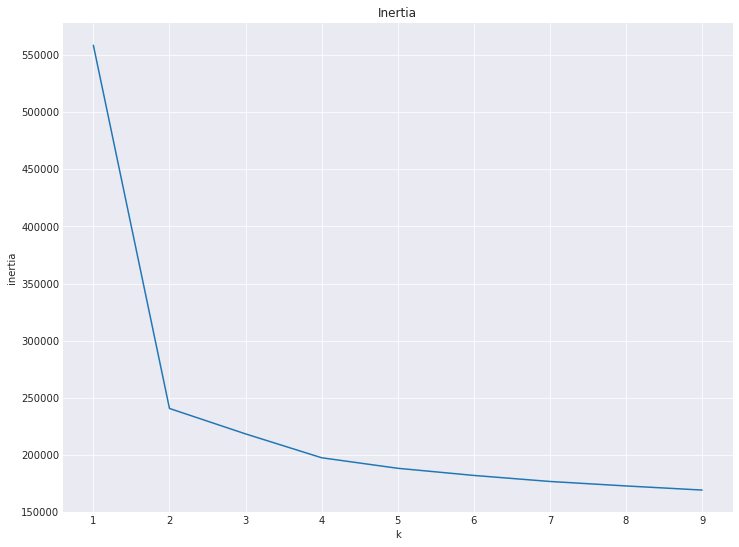

In [55]:
plt.plot(range(1, 10), inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Inertia')

In [56]:
from sklearn.metrics import silhouette_score
silhouette = []
for k_i in range(2, 10):
    kmeans = KMeans(n_clusters=k_i,n_init=10)
    kmeans.fit(X)
    silhouette.append(silhouette_score(X, kmeans.labels_))

print(silhouette)

[0.4810762729942551, 0.32422933603895726, 0.18675768806210324, 0.16496162527899627, 0.13318696173693345, 0.1192816636246171, 0.10349360707811647, 0.10962307572195773]


Text(0.5, 1.0, 'Silhouette')

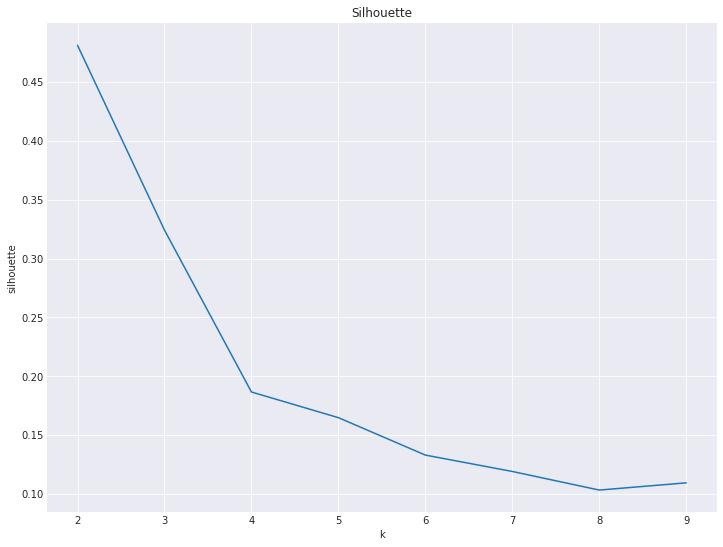

In [58]:
plt.plot(range(2, 10), silhouette);
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('Silhouette')

Попробуем еще один метод кластеризации, агломеративную кластеризацию.

In [91]:
n_classes_optimal=2


In [92]:
ag = AgglomerativeClustering(n_clusters=n_classes_optimal, linkage='ward').fit(X)

In [93]:
km = KMeans(n_clusters=n_classes_optimal,n_init=100,random_state=123).fit(X)

Посчитайте Adjusted Rand Index для разбиений ag и km, где n_classes = подобранное  оптимальное количество кластеров в предыдущем задании.

In [94]:
from sklearn.metrics import adjusted_rand_score
ari_ag = adjusted_rand_score(y,ag.labels_)
ari_km = adjusted_rand_score(y,km.labels_)
print(f'Adjusted Rand Index for AgglomerativeClustering: {ari_ag:.2f}')
print(f'Adjusted Rand Index for KMeans: {ari_km:.2f}')

Adjusted Rand Index for AgglomerativeClustering: 0.33
Adjusted Rand Index for KMeans: 0.33


**Вопрос 2:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

## ДЗ БОНУС 

Попробуйте метод кластеризации DBSCAN c параметрами по умолчанию. Посчитайте для него ARI.

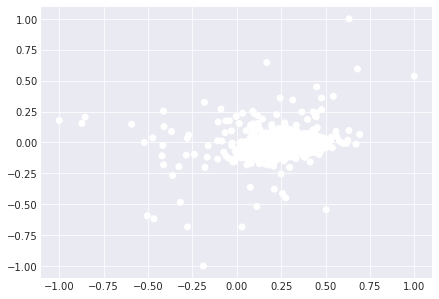

In [96]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN().fit(X)
labels = dbscan.labels_



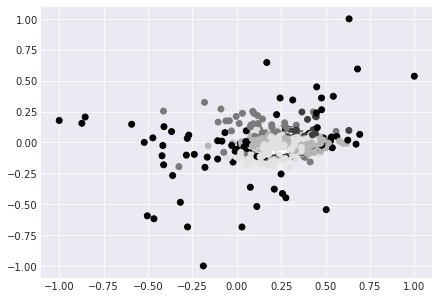

In [98]:
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(X[:, 0], X[:, 1], c=y)

Подберите оптимальные параметры min_samples и eps с помощью эвристики. Описание эвристики можно посмотреть здесь https://habr.com/ru/post/322034/.
Запустите DBSCAN еще раз и посмотрите как изменился ARI.

In [165]:
from scipy.spatial import distance_matrix
dm = distance_matrix(X[:2000, :], X[:2000, :]) #compute the matrix of all pair-wise distances for first 2000 elements

In [ ]:
eps_values = [] #list of eps for DBSCAN
m = 3 # m = min_samples
for r in range(dm.shape[0]):
    sorted_distances = np.sort(dm[r, :]) #sort the vector of distances
    top_m_neighbors_dist = sorted_distances[1:(m+1)] #choose top neighbors from 1st element to m (0 elem = 0) in every vector for r point
    eps_values.append(top_m_neighbors_dist.mean()) #append mean value in eps_values

Text(0, 0.5, 'eps')

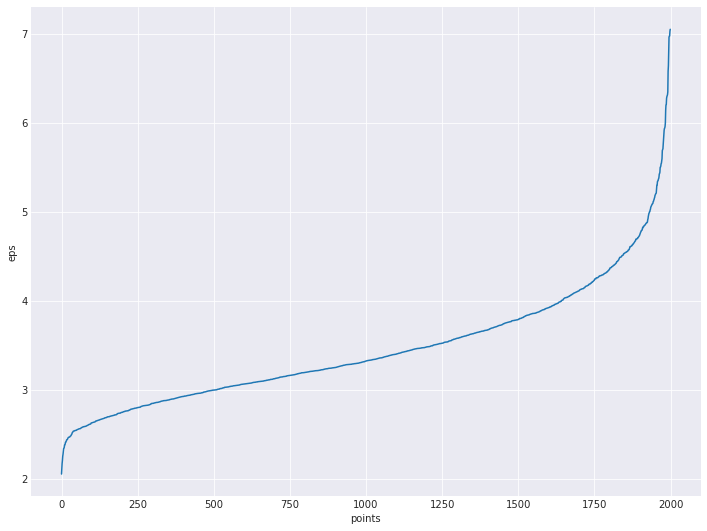

In [178]:
plt.plot(sorted(eps_values))
plt.xlabel('points')
plt.ylabel('eps')

In [167]:
dbscan = DBSCAN(min_samples=3, eps=4.3).fit(X)
labels = dbscan.labels_

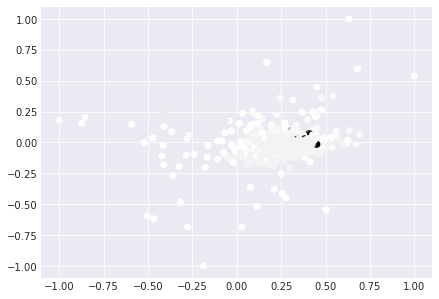

In [168]:
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels)

In [169]:
adjusted_rand_score(y,dbscan.labels_)

0.3249782053335813

In [170]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19])